In [1]:
import sys
sys.path.append("/home/565/mb0427/gdata-gb02/Website/Forecasts/ops_scripts/")
import nclcmaps
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from windspharm.xarray import VectorWind
from windspharm.tools import prep_data, recover_data, order_latdim
import metpy.calc as mpcalc
from metpy.units import units

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-bdw-0160
--------------------------------------------------------------------------


In [2]:
from PIL import Image # pip install Pillow
import sys
import glob
from PIL import ImageOps
import numpy as np
# Trim all png images with white background in a folder
# Usage "python PNGWhiteTrim.py ../someFolder padding"
def crop(path, in_padding=1,**kwargs):
    Image.MAX_IMAGE_PIXELS = None
    
    try:
        padding = int(in_padding)
        padding = np.asarray([-1*padding, -1*padding, padding, padding])
    except :
        print("Usage: python PNGWhiteTrim.py ../someFolder padding")
        sys.exit(1)
    
    filePaths = glob.glob(path) #search for all png images in the folder
    
    if len(filePaths) == 0:
        print("No files detected!")
    
    for filePath in filePaths:
        image=Image.open(filePath)
        image.load()
        imageSize = image.size
    
        # remove alpha channel
        invert_im = image.convert("RGB")
    
        # invert image (so that white is 0)
        invert_im = ImageOps.invert(invert_im)
        imageBox = invert_im.getbbox()
        imageBox = tuple(np.asarray(imageBox)+padding)
    
        cropped=image.crop(imageBox)
        print(filePath, "Size:", imageSize, "New Size:", imageBox)
        cropped.save(filePath)


In [3]:
indatetime=(datetime.today()-relativedelta(days=1)).replace(hour=12, minute=0, second=0, microsecond=0)
#indatetime=datetime(2024,3,31,0,0,0)
home_path='/home/565/mb0427/gdata-gb02/Website/Forecasts/ops_scripts/ACCESS/'
outpath='/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/'

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_24.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


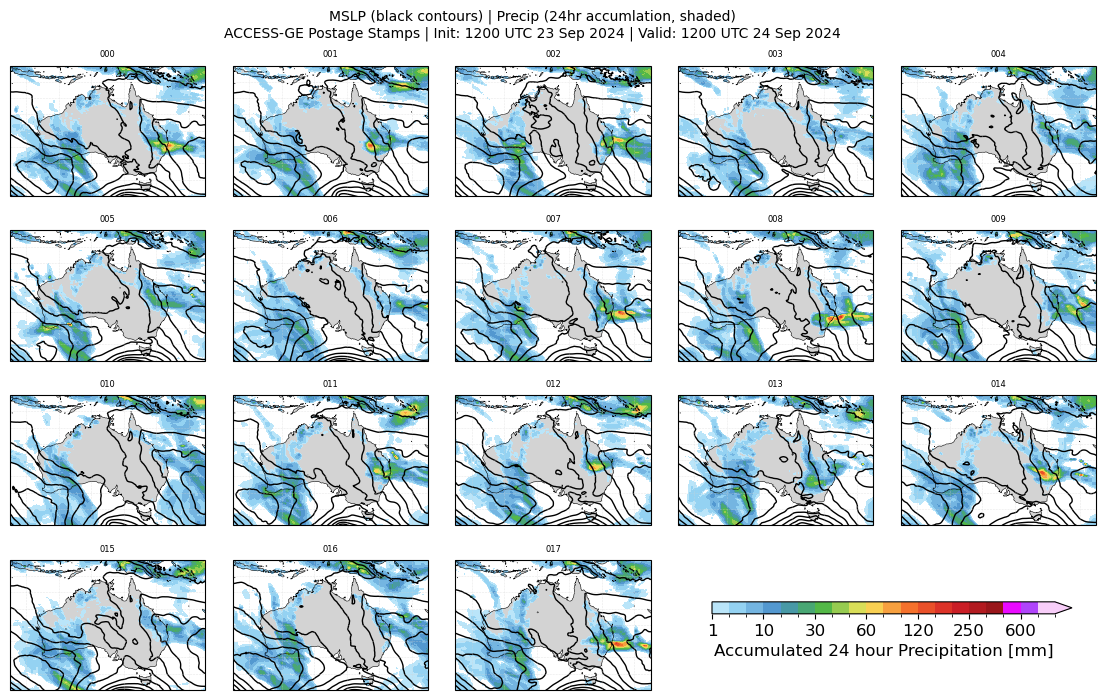

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_48.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


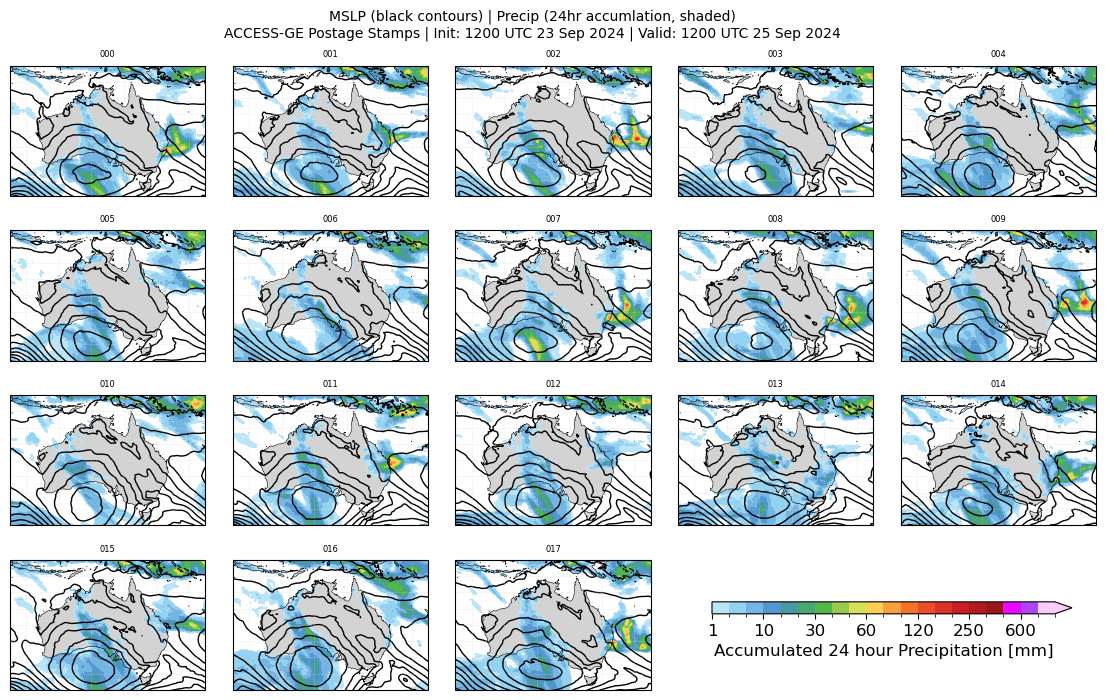

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_72.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


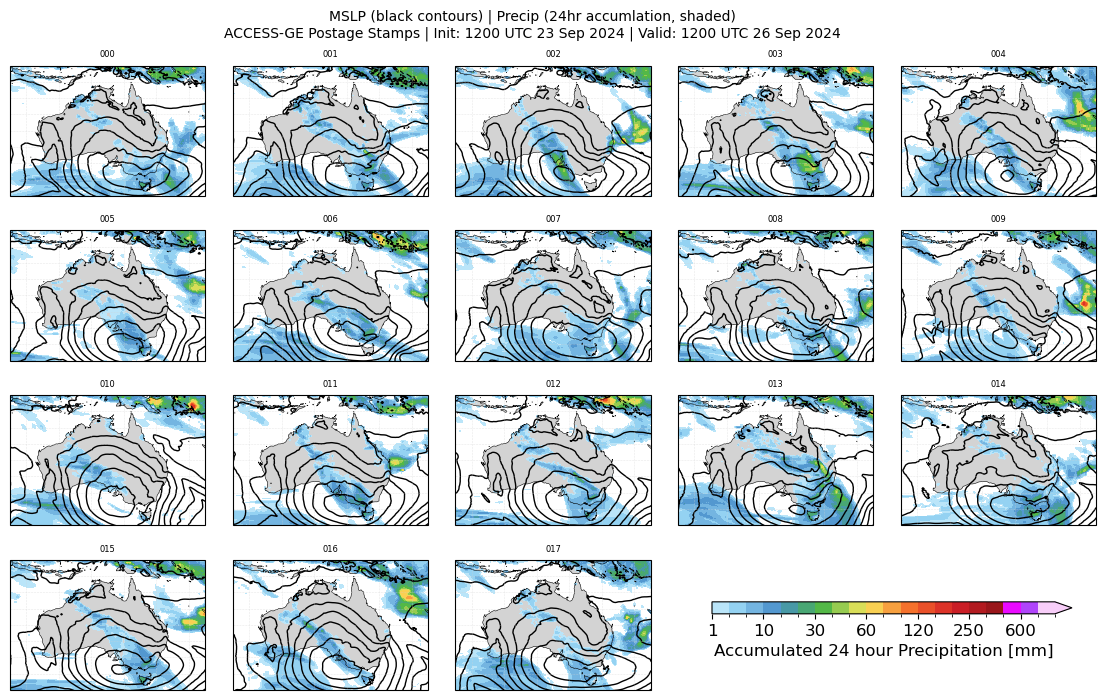

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_96.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


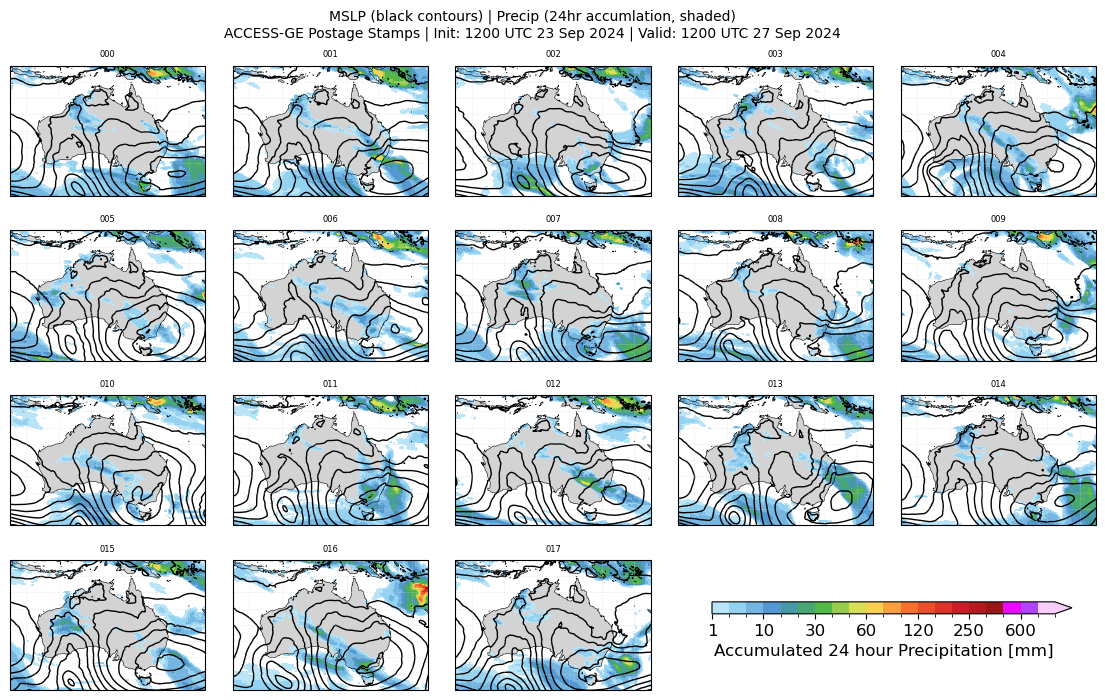

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_120.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


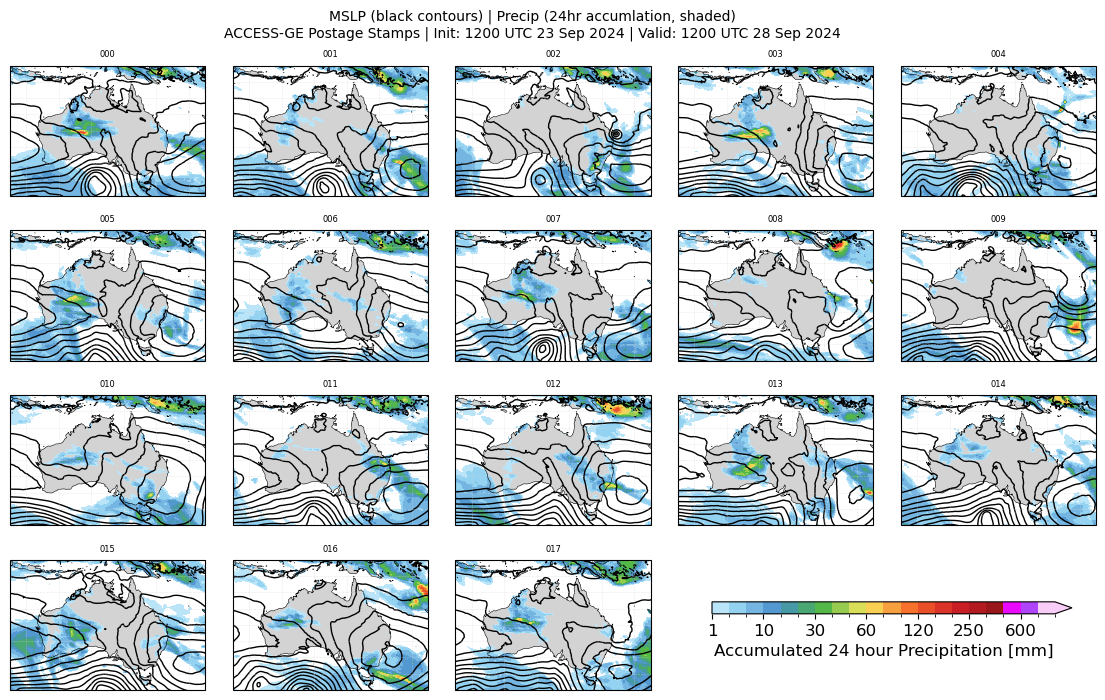

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_144.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


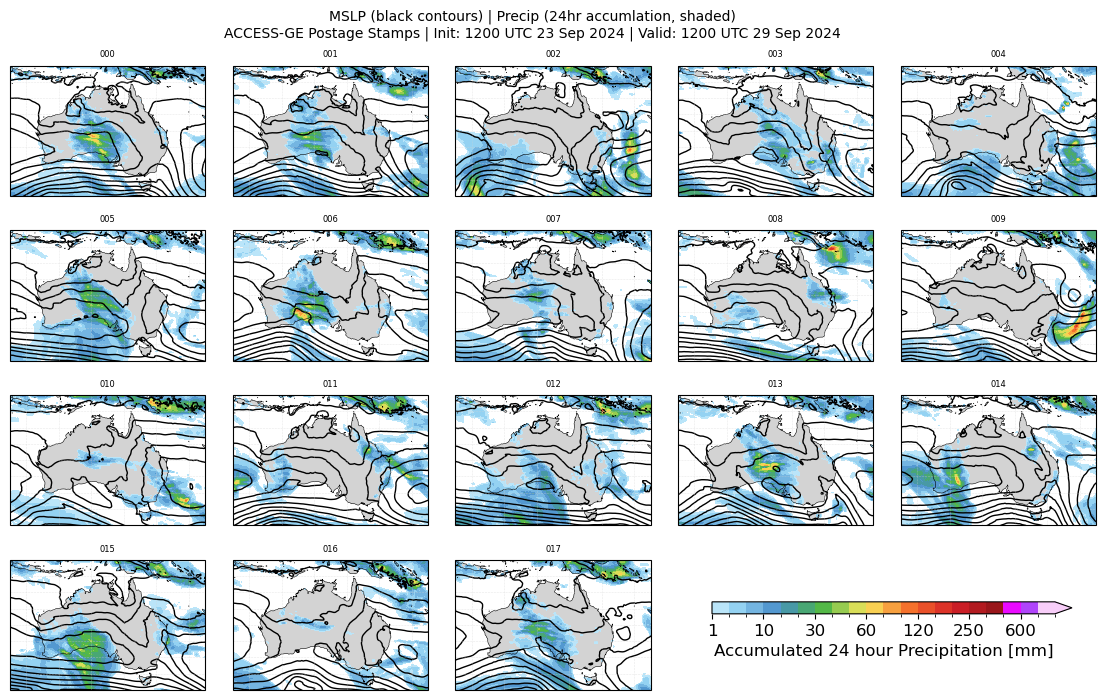

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_168.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


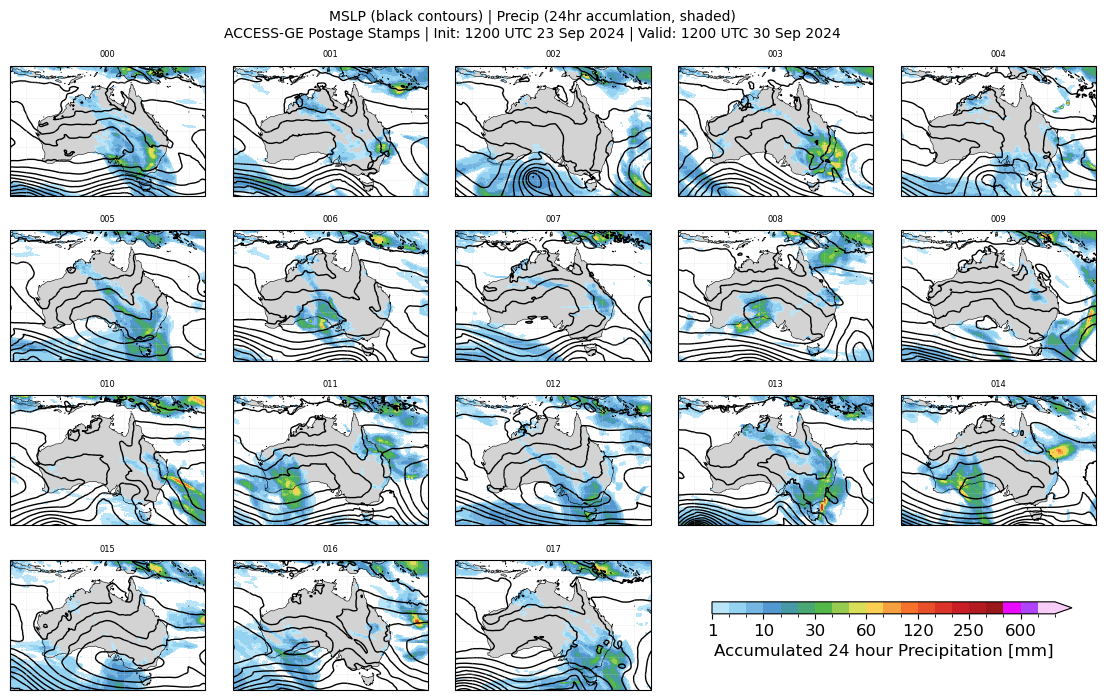

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_192.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


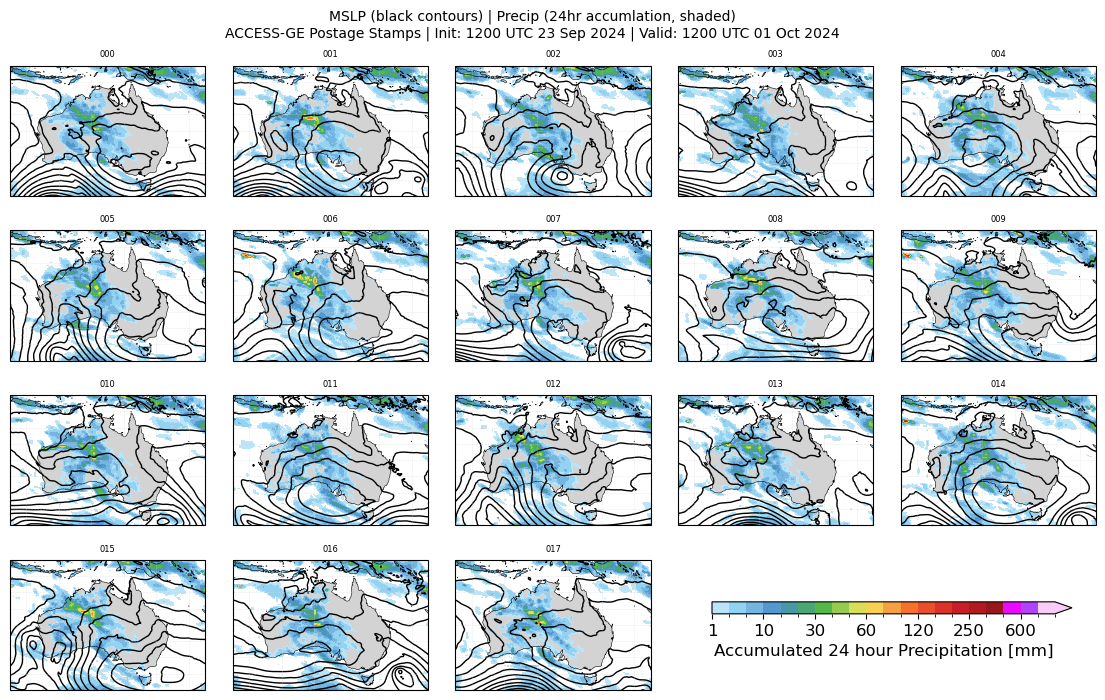

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_216.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


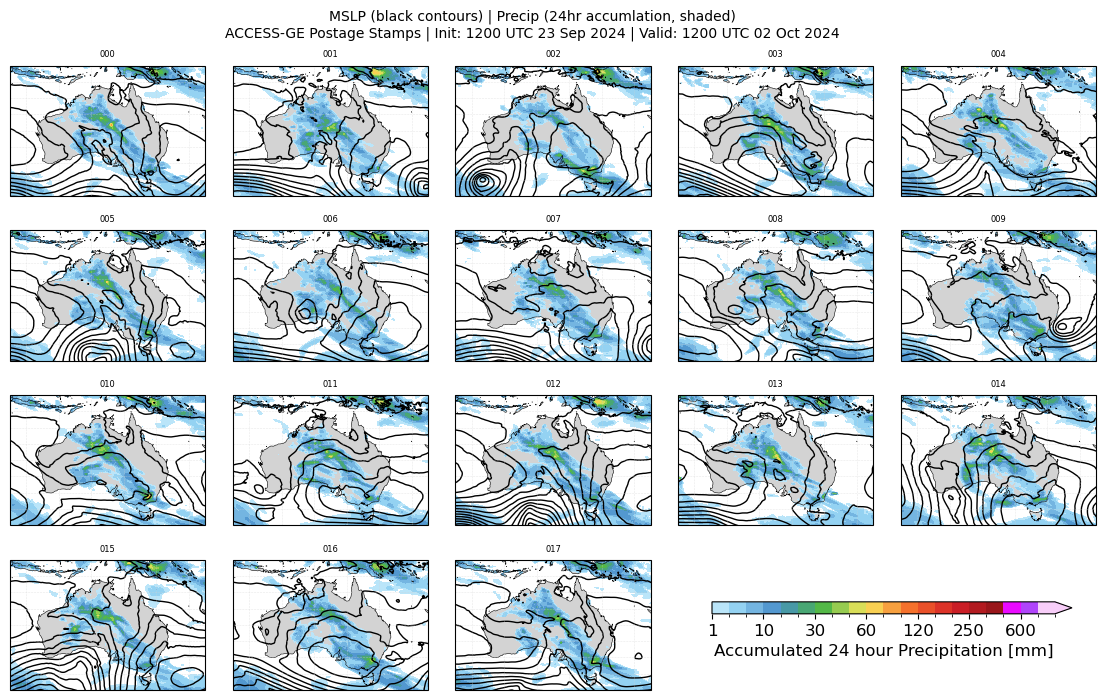

/scratch/gb02/mb0427/Website/Forecasts/BoM/ACCESS-GE/images/ACCESS-GE_Postage_Precip24hr_240.jpg Size: (3600, 2400) New Size: (173, -2, 3555, 2147)


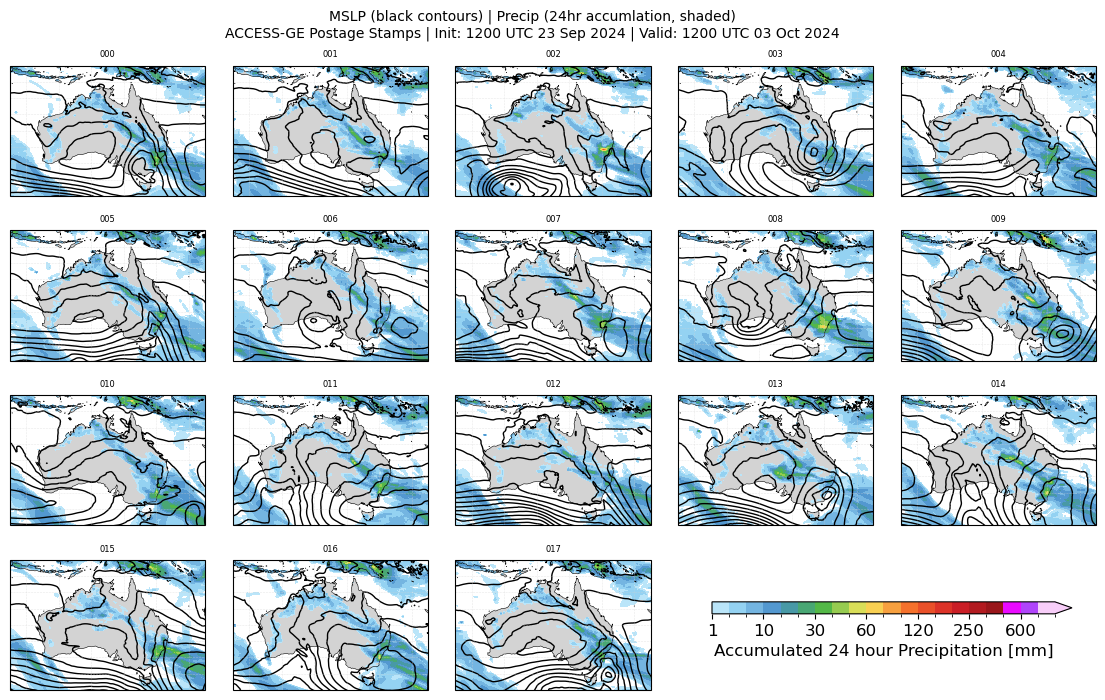

In [10]:
import warnings
warnings.filterwarnings("ignore")

name='Australia'
plot_extent=[105,165,-45,-5]
#plot_extent=[100,160,-45,-5]
centlon=0
figsize=(12,8)
barblength=7
ens_length=17
tstep_length=82
daynum=-1

inrun=indatetime.strftime('%H%M')
indate=indatetime.strftime('%Y%m%d')
for t in range(7,tstep_length,8):#range(7,tstep_length,8):
    tnum=str(int((t+1)/2)*6)
    daynum=int((t+1)/8)-8
    
    fig, axs = plt.subplots(4, 5, figsize=figsize, subplot_kw=dict(projection=ccrs.PlateCarree())) 
    ax_list=axs.reshape(-1)
    
    for i in range(0,ens_length+1):
        ax=ax_list[i]
        ax.set_extent(plot_extent,crs=ccrs.PlateCarree())
        
        i_long=str(i).zfill(3)
        
        runpath='/g/data/lb4/ops_aps3/access-ge/1/'+indate+'/'+inrun
        if i==0:
            ens_path='/cf'
        else:
            ens_path='/pf/'+i_long
        
        fpath=runpath+ens_path+'/sfc/'
        fn=fpath+'accum_prcp.grb'
        prcp=xr.open_dataset(fn,engine='cfgrib',backend_kwargs={"indexpath": outpath+'data/temp_grib.idx'})
        #print(prcp.step)
        prcp=prcp.sel(latitude=slice(plot_extent[3]+5,plot_extent[2]-5),longitude=slice(plot_extent[0]-5,plot_extent[1]+5))
        if daynum==0:
            prcp24=prcp.isel(step=(daynum+1)*24-1)
            #prcp24=prcp.isel(step=daynum)
        else:
            #prcp24=prcp.isel(step=(daynum+1)*24-1)
            prcp24=prcp.isel(step=(daynum+1)*24-1)-prcp.isel(step=(daynum)*24-1)
        
        fpath=runpath+ens_path+'/sfc/'
        fn=fpath+'mslp.grb'
        mslp=xr.open_dataset(fn,engine='cfgrib',backend_kwargs={"indexpath": outpath+'data/temp_grib.idx'}).isel(step=t)
        mslp=mslp.sel(latitude=slice(plot_extent[3]+5,plot_extent[2]-5),longitude=slice(plot_extent[0]-5,plot_extent[1]+5))
        
        dt=datetime.strptime(str(mslp.valid_time.values),'%Y-%m-%dT%H:%M:%S.000000000')
        init_dt=datetime.strptime(str(mslp.time.values),'%Y-%m-%dT%H:%M:%S.000000000')

        dstr=dt.strftime('%Y%m%d_%H')
        dstr_long=dt.strftime('%H%M UTC %d %b %Y')
        dstr_init_long=init_dt.strftime('%H%M UTC %d %b %Y')

        rain_levels =  [1,2,5,10,15,20,30,40,50,60,80,100,120,150,200,250,300,400,600,800,1000]
        cmap = nclcmaps.cmap('WhiteBlueGreenYellowRed')(range(26,256,int(np.floor(256/len(rain_levels)+2))))
        cmap = ListedColormap(np.concatenate([cmap,nclcmaps.cmap('MPL_gist_nca')(range(102,129,7))]))
        cf=ax.contourf(prcp24.longitude,prcp24.latitude,prcp24.unknown,levels=rain_levels,
                norm=BoundaryNorm(rain_levels,len(rain_levels)),cmap=cmap,extend='max',
                transform=ccrs.PlateCarree())
        plot_levels = list(range(800,1400,4))
        cmslp=ax.contour(mslp.longitude,mslp.latitude,mslp.prmsl/100,levels=plot_levels,
                         colors='black',linewidths=1,linestyles='-',
                         transform=ccrs.PlateCarree())
        
        ax.add_feature(LAND,facecolor='lightgrey')
        ax.coastlines(linewidths=0.4)
        gl = ax.gridlines(transform=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.4, color='lightgrey', alpha=0.5, linestyle='--')
        
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        gl.left_labels = False
        
        if i==18:
            ax.set_title('Control', fontsize=6)
        else:
            ax.set_title(i_long, fontsize=6)
    
    ax_list[-1].set_axis_off()
    ax_list[-2].set_axis_off()
        
    fig.tight_layout(w_pad=0.1)
    fig.subplots_adjust(left=0.065, right=0.97, top=0.93, bottom=0.11, wspace=0.14)

    fig.suptitle('MSLP (black contours) | Precip (24hr accumlation, shaded)\nACCESS-GE Postage Stamps | Init: ' + dstr_init_long +' | Valid: '+dstr_long, 
              fontsize=10)
    
    ax_pos=[0.65,0.225,0.3,0.015] #[left, bottom, width, height]
    #fig=plt.gcf()
    cbar_ax = fig.add_axes(ax_pos)
    cb=fig.colorbar(cf,orientation="horizontal", cax=cbar_ax)
    cb.ax.tick_params(labelsize=12)
    cb.set_label('Accumulated 24 hour Precipitation [mm]', rotation=0, fontsize=12)
    
    outfile=outpath+'images/ACCESS-GE_Postage_Precip24hr_'+tnum+'.jpg'
    plt.savefig(outfile, dpi=300)
    crop(outfile,in_padding=50)
    plt.show()